<a href="https://colab.research.google.com/github/somilasthana/deeplearningtutorial/blob/master/DELF_Extracting_Image_Features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:

!pip install -q 'tensorflow>=1.7'
!pip install -q 'tensorflow-hub>=0.1.0'
!pip install -q 'scikit-image'

In [0]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
from scipy.spatial import cKDTree
from skimage.feature import plot_matches
from skimage.measure import ransac
from skimage.transform import AffineTransform
from six import BytesIO
import tensorflow as tf
import tensorflow_hub as hub
from six.moves.urllib.request import urlopen

In [0]:
IMAGE_1_URL = 'https://upload.wikimedia.org/wikipedia/commons/2/28/Bridge_of_Sighs%2C_Oxford.jpg'
IMAGE_2_URL = 'https://upload.wikimedia.org/wikipedia/commons/c/c3/The_Bridge_of_Sighs_and_Sheldonian_Theatre%2C_Oxford.jpg'


IMAGE_1_URL = 'https://upload.wikimedia.org/wikipedia/commons/thumb/1/1d/Taj_Mahal_%28Edited%29.jpeg/640px-Taj_Mahal_%28Edited%29.jpeg'
IMAGE_2_URL = 'https://upload.wikimedia.org/wikipedia/commons/thumb/f/f5/Taj_Mahal_2012.jpg/640px-Taj_Mahal_2012.jpg'

#IMAGE_1_URL = 'https://upload.wikimedia.org/wikipedia/commons/2/2d/Parthenon-Restoration-Nov-2005-a.jpg'
#IMAGE_2_URL = 'https://upload.wikimedia.org/wikipedia/commons/5/57/White_House_06.02.08.jpg'

In [0]:
IMAGE_1_JPG = 'image_1.jpg'
IMAGE_2_JPG = 'image_2.jpg'

In [0]:
def download_and_resize_image(url, filename, new_width=256, new_height=256):
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert('RGB')
  pil_image_rgb.save(filename, format='JPEG', quality=90)

In [0]:
download_and_resize_image(IMAGE_1_URL, IMAGE_1_JPG)
download_and_resize_image(IMAGE_2_URL, IMAGE_2_JPG)

In [0]:
def show_images(image_path_list):
  plt.figure()
  for i, image_path in enumerate(image_path_list):
    plt.subplot(1, len(image_path_list), i+1)
    plt.imshow(np.asarray(Image.open(image_path)))
    plt.title(image_path)
    plt.grid(False)
    plt.yticks([])
    plt.xticks([])
  plt.show()

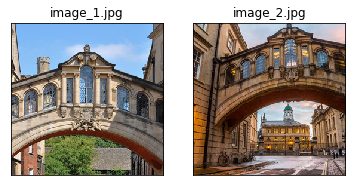

In [8]:
show_images([IMAGE_1_JPG, IMAGE_2_JPG])

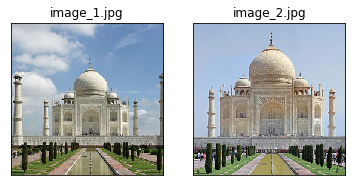

In [99]:
show_images([IMAGE_1_JPG, IMAGE_2_JPG])

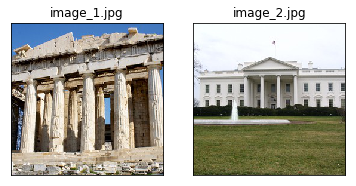

In [80]:
show_images([IMAGE_1_JPG, IMAGE_2_JPG])

In [0]:
def image_input_fn():
  filename_queue = tf.train.string_input_producer(
      [IMAGE_1_JPG, IMAGE_2_JPG], shuffle=False)
  reader = tf.WholeFileReader()
  _, value = reader.read(filename_queue)
  image_tf = tf.image.decode_jpeg(value, channels=3)
  return tf.image.convert_image_dtype(image_tf, tf.float32)

In [0]:
tf.reset_default_graph()

In [0]:
m = hub.Module('https://tfhub.dev/google/delf/1')


In [0]:
image_placeholder = tf.placeholder(
    tf.float32, shape=(None, None, 3), name='input_image')

module_inputs = {
    'image': image_placeholder,
    'score_threshold': 100.0,
    'image_scales': [0.25, 0.3536, 0.5, 0.7071, 1.0, 1.4142, 2.0],
    'max_feature_num': 1000,
}

In [0]:
module_outputs = m(module_inputs, as_dict=True)

In [0]:
image_tf = image_input_fn()

In [105]:
with tf.train.MonitoredSession() as sess:
  results_dict = {}  # Stores the locations and their descriptors for each image
  for image_path in [IMAGE_1_JPG, IMAGE_2_JPG]:
    image = sess.run(image_tf)
    print('Extracting locations and descriptors from %s' % image_path)
    results_dict[image_path] = sess.run(
        [module_outputs['locations'], module_outputs['descriptors']],
        feed_dict={image_placeholder: image})

Extracting locations and descriptors from image_1.jpg
Extracting locations and descriptors from image_2.jpg


In [0]:
distance_threshold = 0.8
locations_1, descriptors_1 = results_dict[IMAGE_1_JPG]
num_features_1 = locations_1.shape[0]
locations_2, descriptors_2 = results_dict[IMAGE_2_JPG]
num_features_2 = locations_2.shape[0]

In [107]:
num_features_1, num_features_2

(210, 244)

In [69]:
descriptors_1[0, 0:40]

array([-0.28040233, -0.08910675, -0.05954102,  0.02096676,  0.05161274,
       -0.24549733,  0.11106376,  0.0808516 ,  0.18299913, -0.15868913,
       -0.00944419, -0.12390199, -0.19553567,  0.2986657 , -0.08224373,
       -0.11798527, -0.05318618,  0.05378349, -0.10190006, -0.20152941,
        0.27150652, -0.04515339, -0.05829431,  0.16962627,  0.07548948,
        0.03085835, -0.11608029, -0.10821627, -0.03340647,  0.14228289,
       -0.2861737 , -0.07874479, -0.13892148, -0.27125317,  0.08392518,
        0.0853805 , -0.3021387 ,  0.2832171 ,  0.12349688,  0.07425079],
      dtype=float32)

In [70]:
locations_1[0, :]

array([  0., 240.], dtype=float32)

In [0]:
# Find nearest-neighbor matches using a KD tree.
  d1_tree = cKDTree(descriptors_1)
  _, indices = d1_tree.query(
      descriptors_2, distance_upper_bound=distance_threshold)

In [110]:
indices[0]

0

In [0]:
locations_2_to_use = np.array([
      locations_2[i,]
      for i in range(num_features_2)
      if indices[i] != num_features_1
  ])

In [0]:
locations_1_to_use = np.array([
      locations_1[indices[i],]
      for i in range(num_features_2)
      if indices[i] != num_features_1
  ])

In [113]:
 _, inliers = ransac(
      (locations_1_to_use, locations_2_to_use),
      AffineTransform,
      min_samples=3,
      residual_threshold=20,
      max_trials=1000)

print('Found %d inliers' % sum(inliers))

/usr/local/lib/python3.6/dist-packages/skimage/transform/_geometric.py:683: RuntimeWarning: divide by zero encountered in true_divide
  H.flat[list(self._coeffs) + [8]] = - V[-1, :-1] / V[-1, -1]
/usr/local/lib/python3.6/dist-packages/skimage/transform/_geometric.py:687: RuntimeWarning: invalid value encountered in matmul
  H = np.linalg.inv(dst_matrix) @ H @ src_matrix
/usr/local/lib/python3.6/dist-packages/skimage/measure/fit.py:831: RuntimeWarning: invalid value encountered in less
  sample_model_inliers = sample_model_residuals < residual_threshold


Found 143 inliers


Text(0.5, 1.0, 'DELF correspondences')

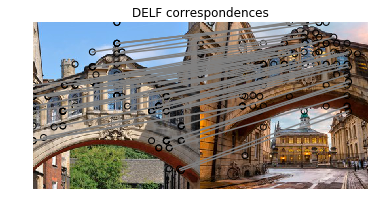

In [76]:
_, ax = plt.subplots()
img_1 = mpimg.imread(IMAGE_1_JPG)
img_2 = mpimg.imread(IMAGE_2_JPG)
inlier_idxs = np.nonzero(inliers)[0]
plot_matches(
      ax,
      img_1,
      img_2,
      locations_1_to_use,
      locations_2_to_use,
      np.column_stack((inlier_idxs, inlier_idxs)),
      matches_color='gray')
ax.axis('off')
ax.set_title('DELF correspondences')

Text(0.5, 1.0, 'DELF correspondences')

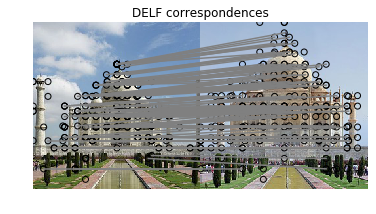

In [114]:
_, ax = plt.subplots()
img_1 = mpimg.imread(IMAGE_1_JPG)
img_2 = mpimg.imread(IMAGE_2_JPG)
inlier_idxs = np.nonzero(inliers)[0]
plot_matches(
      ax,
      img_1,
      img_2,
      locations_1_to_use,
      locations_2_to_use,
      np.column_stack((inlier_idxs, inlier_idxs)),
      matches_color='gray')
ax.axis('off')
ax.set_title('DELF correspondences')

Text(0.5, 1.0, 'DELF correspondences')

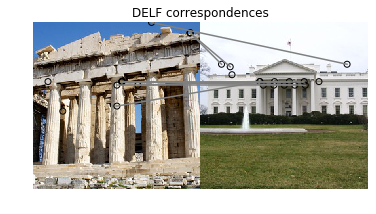

In [95]:
_, ax = plt.subplots()
img_1 = mpimg.imread(IMAGE_1_JPG)
img_2 = mpimg.imread(IMAGE_2_JPG)
inlier_idxs = np.nonzero(inliers)[0]
plot_matches(
      ax,
      img_1,
      img_2,
      locations_1_to_use,
      locations_2_to_use,
      np.column_stack((inlier_idxs, inlier_idxs)),
      matches_color='gray')
ax.axis('off')
ax.set_title('DELF correspondences')